# Extract Text from Image
This notebook extracts text from the entire image without dividing it into regions.

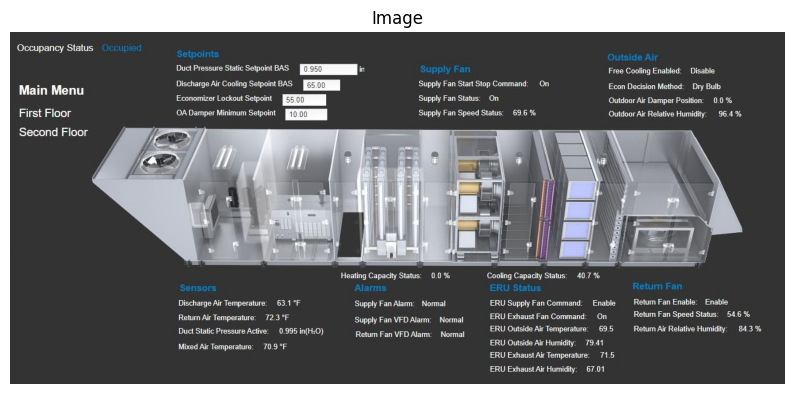

Extracted Text:
Occupancy Status !

Duct Pressure Static Setpoint BAS EEN Supply Fan Free Cooling Enabled: Disable
Mai nu — ‘Air Cooling oe BAS 65.00 | ‘Supply Fan Start Stop Command: On. Econ Decision Method: Dry Bulb
Economizer Lockout Setpoint f55.00 | ‘Supply Fan Status: On Outdoor Air Damper Position: 0.0 %

First Floor wm Setpoint [ETT Supply Fan Speed Status: 69.6 % Outdoor Air Relative Humidity: 96.4 %

Second Floor

Heating Capacity Status: 0.0 % Cooling Capacity Status: 40.7 %
ensors Alarms ERU Status Return Fai
Discharge Air Temperature: 63.1 °F ‘Supply Fan Alarm: Normal ERU Supply Fan Command: Enable Return Fan Enable: Enable
Return Air Temperature: 72.3 °F ‘Supply Fan VFD Alarm: Normal ERU Exhaust Fan Command: On Retum Fan Speed Status: 54.6 %
Duct Static Pressure Active: 0.99: ERU Outside Air Temperature: 69.5 Return Air Relative Humidity: 84.3%

Retum Fan VFD Alarm: Normal
ERU Outside Air Humidity: 79.41

ERU Exhaust Air Temperature: 71.5
ERU Exhaust Air Humidity: 67.01


In [1]:
import pytesseract
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Specify the path to tesseract.exe
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\bbartling\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

# Function to extract text from an image
def image_to_text(image_path):
    image = cv2.imread(image_path)
    text = pytesseract.image_to_string(image)
    return text

# Function to display the image
def display_image(image_path):
    image = cv2.imread(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image')
    plt.axis('off')
    plt.show()

# Specify the path to your image
image_path = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\data\ahu\ahu_not_typ_ducting.jpg'

# Display the image
display_image(image_path)

# Extract text from the image
extracted_text = image_to_text(image_path)

# Print the extracted text
print("Extracted Text:")
print(extracted_text)

In [3]:
import os
import requests
import json

# Load configuration from file
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

# Retrieve the API key from the configuration
API_KEY = config.get("API_KEY")

# Ensure the API key is available
if not API_KEY:
    raise ValueError("API key not found in environment variables")

# Set up the API URL and headers
API_URL = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-v0.1"
headers = {"Authorization": f"Bearer {API_KEY}"}

# Example telemetry data (instantaneous readings)
duct_static_pressure = 0.3
duct_static_setpoint = 0.4
fan_vfd_speed = 96

# Function to generate a response using the API
def generate_response(prompt):
    # Prepare the payload
    data = {
        "inputs": prompt,
        "parameters": {
            "max_length": 200,  # Adjust max_length for concise responses
            "temperature": 0.5,  # Adjust the creativity of the response
            "top_p": 0.95,  # Use nucleus sampling
            "num_return_sequences": 1  # Return only one response
        }
    }

    # Make the request to the Hugging Face Inference API
    response = requests.post(API_URL, headers=headers, json=data)

    # Debugging: print status code and response content
    print(f"Status Code: {response.status_code}")
    print(f"Response Content: {response.text}")

    try:
        response_json = response.json()
    except ValueError:
        print("Failed to decode JSON response")
        return ""

    # Print the response from the model
    if isinstance(response_json, list):
        return response_json[0].get("generated_text", "").strip()
    else:
        print("Error:", response_json)
        return ""

# Define the fault detection logic and data in the prompt
prompt = (
    "You are an advanced virtual AI HVAC assistant specialized in fault detection telemetry.\n"
    "Here is the telemetry data from a VAV AHU system:\n"
    f"- Duct Static Pressure: {duct_static_pressure} inches\n"
    f"- Duct Static Setpoint: {duct_static_setpoint} inches\n"
    f"- Fan VFD Speed: {fan_vfd_speed}%\n\n"
    "Using the ASHRAE G36 fault detection logic:\n"
    "If the duct static pressure is less than the setpoint minus 0.1 inches AND the fan VFD speed is greater than or equal to 90%, flag a fault.\n"
    "Return only the fault condition flag (0 for no fault, 1 for fault) and explain the result in simple terms mechanical engineering theory for a building operator on how a variable volume supply fan achieves a duct static pressure."
)

# Generate and print the response
assistant_reply = generate_response(prompt)
print("Assistant:", assistant_reply)


Status Code: 200
Response Content: [{"generated_text":"You are an advanced virtual AI HVAC assistant specialized in fault detection telemetry.\nHere is the telemetry data from a VAV AHU system:\n- Duct Static Pressure: 0.3 inches\n- Duct Static Setpoint: 0.4 inches\n- Fan VFD Speed: 96%\n\nUsing the ASHRAE G36 fault detection logic:\nIf the duct static pressure is less than the setpoint minus 0.1 inches AND the fan VFD speed is greater than or equal to 90%, flag a fault.\nReturn only the fault condition flag (0 for no fault, 1 for fault) and explain the result in simple terms mechanical engineering theory for a building operator on how a variable volume supply fan achieves a duct static pressure.\n\nYour answer:\n\nThe fault condition is 0. The duct static pressure is less than the setpoint minus 0.1 inches, but the fan VFD speed is less than 90%.\n\nA variable volume supply fan achieves a duct static pressure by adjusting the speed of the fan. When the fan speed is increased, the airf